## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
f = open("complaints.json") # Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.

df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [4]:
#print the column names
print(df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [5]:
df.columns = ["index", 'request_type', 'request_id', 'request_score', 'request_tags', 'request_zip_code',
       'request_complaint_id', 'request_issue', 'request_date_received',
       'request_state', 'request_consumer_disputed', 'request_product',
       'request_company_response', 'request_company', 'request_submitted_via',
       'request_date_sent_to_company', 'request_company_public_response',
       'request_sub_product', 'request_timely',
       'request_complaint_what_happened', 'request_sub_issue',
       'request_consumer_consent_provided']

In [6]:
print(df.columns)

Index(['index', 'request_type', 'request_id', 'request_score', 'request_tags',
       'request_zip_code', 'request_complaint_id', 'request_issue',
       'request_date_received', 'request_state', 'request_consumer_disputed',
       'request_product', 'request_company_response', 'request_company',
       'request_submitted_via', 'request_date_sent_to_company',
       'request_company_public_response', 'request_sub_product',
       'request_timely', 'request_complaint_what_happened',
       'request_sub_issue', 'request_consumer_consent_provided'],
      dtype='object')


In [7]:
df.head()

,index,request_type,request_id,request_score,request_tags,request_zip_code,request_complaint_id,request_issue,request_date_received,request_state,...,request_company_response,request_company,request_submitted_via,request_date_sent_to_company,request_company_public_response,request_sub_product,request_timely,request_complaint_what_happened,request_sub_issue,request_consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [8]:
#Assign nan in place of blanks in the complaints column
df['request_complaint_what_happened'] = df['request_complaint_what_happened'].replace(r'^\s*$', np.nan, regex=True)


In [9]:
print(df['request_complaint_what_happened'].isna().sum())

57241


In [10]:
#Remove all rows where complaints column is nan
df = df.dropna(subset=['request_complaint_what_happened'])
df = df.reset_index()

In [11]:
df

,level_0,index,request_type,request_id,request_score,request_tags,request_zip_code,request_complaint_id,request_issue,request_date_received,...,request_company_response,request_company,request_submitted_via,request_date_sent_to_company,request_company_public_response,request_sub_product,request_timely,request_complaint_what_happened,request_sub_issue,request_consumer_consent_provided
0,1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
1,2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
2,10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
3,11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
4,14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,78303,complaint-public-v2,complaint,3094545,0.0,Older American,281XX,3094545,"Advertising and marketing, including promotion...",2018-12-07T12:00:00-05:00,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2018-12-07T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,After being a Chase Card customer for well ove...,Didn't receive advertised or promotional terms,Consent provided
21068,78309,complaint-public-v2,complaint,3091984,0.0,None,934XX,3091984,"Other features, terms, or problems",2018-12-05T12:00:00-05:00,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Other problem,Consent provided
21069,78310,complaint-public-v2,complaint,3133355,0.0,None,923XX,3133355,Problem with a lender or other company chargin...,2019-01-25T12:00:00-05:00,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-01-25T12:00:00-05:00,None,Checking account,Yes,I am not familiar with XXXX pay and did not un...,Transaction was not authorized,Consent provided
21070,78311,complaint-public-v2,complaint,3110963,0.0,None,None,3110963,"Other features, terms, or problems",2018-12-27T12:00:00-05:00,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-27T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I have had flawless credit for 30 yrs. I've ha...,Problem with balance transfer,Consent provided


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [12]:
import re

In [13]:
# Write your function here to clean the text and remove all the unnecessary elements.

def text_clean(txt):
    #txt = str(txt)
    txt = txt.lower()
    txt = re.sub("\(.*?\)","",txt)
    txt = re.sub(r'[^\w\s]', '', txt)
    txt = re.sub(r"[A-Za-z]+\d+|\d+[A-Za-z]+",'',txt).strip()
    return txt


In [14]:
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [15]:
#Write your function to Lemmatize the texts

def text_lemmatization(sentence):
    word_list = nltk.word_tokenize(sentence)
    lemmatized_list = ' '.join([lemmatizer.lemmatize(word) for word in word_list])
    return lemmatized_list


In [16]:
#df2 = df[['request_complaint_what_happened']]
#df2.head()

In [17]:
df['request_complaint_what_happened_clean'] = df['request_complaint_what_happened'].apply(lambda x: text_clean(x))

In [18]:
df.shape

(21072, 24)

In [19]:
df.head()

,level_0,index,request_type,request_id,request_score,request_tags,request_zip_code,request_complaint_id,request_issue,request_date_received,...,request_company,request_submitted_via,request_date_sent_to_company,request_company_public_response,request_sub_product,request_timely,request_complaint_what_happened,request_sub_issue,request_consumer_consent_provided,request_complaint_what_happened_clean
0,1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,...,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is xxxx xxxx and i apprec...
1,2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,...,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,i upgraded my xxxx xxxx card in and was told ...
2,10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,...,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,chase card was reported on however fraudulent...
3,11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,...,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,on while trying to book a xxxx xxxx ticket ...
4,14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,...,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for 160000 i deposi...


In [20]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df['lemmatized_request_complaint_what_happened'] = df['request_complaint_what_happened_clean'].apply(lambda x: text_lemmatization(x))
df.head()

,level_0,index,request_type,request_id,request_score,request_tags,request_zip_code,request_complaint_id,request_issue,request_date_received,...,request_submitted_via,request_date_sent_to_company,request_company_public_response,request_sub_product,request_timely,request_complaint_what_happened,request_sub_issue,request_consumer_consent_provided,request_complaint_what_happened_clean,lemmatized_request_complaint_what_happened
0,1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,...,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...
1,2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,...,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,i upgraded my xxxx xxxx card in and was told ...,i upgraded my xxxx xxxx card in and wa told by...
2,10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,...,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,chase card was reported on however fraudulent...,chase card wa reported on however fraudulent a...
3,11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,...,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,on while trying to book a xxxx xxxx ticket ...,on while trying to book a xxxx xxxx ticket i c...
4,14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,...,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for 160000 i deposi...,my grand son give me check for 160000 i deposi...


In [21]:
df_clean = df[['request_complaint_what_happened_clean', 'lemmatized_request_complaint_what_happened']]

In [22]:
df_clean

,request_complaint_what_happened_clean,lemmatized_request_complaint_what_happened
0,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...
1,i upgraded my xxxx xxxx card in and was told ...,i upgraded my xxxx xxxx card in and wa told by...
2,chase card was reported on however fraudulent...,chase card wa reported on however fraudulent a...
3,on while trying to book a xxxx xxxx ticket ...,on while trying to book a xxxx xxxx ticket i c...
4,my grand son give me check for 160000 i deposi...,my grand son give me check for 160000 i deposi...
...,...,...
21067,after being a chase card customer for well ove...,after being a chase card customer for well ove...
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...
21069,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...
21070,i have had flawless credit for 30 yrs ive had ...,i have had flawless credit for 30 yr ive had c...


In [23]:
#Write your function to extract the POS tags 

def pos_tag(text):
    # write your code here
    doc = nlp(text)
    tag_list = []
    for tok in doc:
        if (tok.tag_ != 'NN'):
            continue
        tag_list.append(tok.text)
    return ' '.join(tag_list)
    

df_clean["complaint_POS_removed"] =  df['lemmatized_request_complaint_what_happened'].apply(lambda x: pos_tag(x))#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


C:\Users\jamsh\AppData\Local\Temp\ipykernel_16888\1747544207.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [24]:
df_clean

,request_complaint_what_happened_clean,lemmatized_request_complaint_what_happened,complaint_POS_removed
0,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop service debt verification st...
1,i upgraded my xxxx xxxx card in and was told ...,i upgraded my xxxx xxxx card in and wa told by...,agent anniversary date agent information order...
2,chase card was reported on however fraudulent...,chase card wa reported on however fraudulent a...,chase card application identity consent servic...
3,on while trying to book a xxxx xxxx ticket ...,on while trying to book a xxxx xxxx ticket i c...,ticket offer ticket reward card information of...
4,my grand son give me check for 160000 i deposi...,my grand son give me check for 160000 i deposi...,son check chase account fund chase bank accoun...
...,...,...,...
21067,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,credit card provider claim purchase protection...
21069,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,pay risk consumer chase bank app chase year ba...
21070,i have had flawless credit for 30 yrs ive had ...,i have had flawless credit for 30 yr ive had c...,credit yr chase credit card chase freedom prob...


In [25]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,request_complaint_what_happened_clean,lemmatized_request_complaint_what_happened,complaint_POS_removed
0,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop service debt verification st...
1,i upgraded my xxxx xxxx card in and was told ...,i upgraded my xxxx xxxx card in and wa told by...,agent anniversary date agent information order...
2,chase card was reported on however fraudulent...,chase card wa reported on however fraudulent a...,chase card application identity consent servic...
3,on while trying to book a xxxx xxxx ticket ...,on while trying to book a xxxx xxxx ticket i c...,ticket offer ticket reward card information of...
4,my grand son give me check for 160000 i deposi...,my grand son give me check for 160000 i deposi...,son check chase account fund chase bank accoun...
...,...,...,...
21067,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,credit card provider claim purchase protection...
21069,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,pay risk consumer chase bank app chase year ba...
21070,i have had flawless credit for 30 yrs ive had ...,i have had flawless credit for 30 yr ive had c...,credit yr chase credit card chase freedom prob...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [26]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean['complaint_len'] = df_clean['complaint_POS_removed'].apply(lambda x: len(x))

C:\Users\jamsh\AppData\Local\Temp\ipykernel_16888\898437016.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [27]:
df_clean['complaint_len']

0        133
1         95
2         73
3        364
4        157
        ... 
21067    197
21068    601
21069    642
21070    475
21071    199
Name: complaint_len, Length: 21072, dtype: int64

(array([4.142e+03, 5.321e+03, 3.797e+03, 2.583e+03, 1.586e+03, 1.064e+03,
        6.710e+02, 5.490e+02, 4.040e+02, 2.690e+02, 1.820e+02, 9.900e+01,
        7.100e+01, 6.000e+01, 4.500e+01, 3.100e+01, 2.800e+01, 1.900e+01,
        2.300e+01, 2.100e+01, 1.100e+01, 9.000e+00, 1.100e+01, 8.000e+00,
        4.000e+00, 8.000e+00, 2.000e+00, 6.000e+00, 3.000e+00, 4.000e+00,
        4.000e+00, 3.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        3.000e+00, 4.000e+00, 3.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        2.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+0

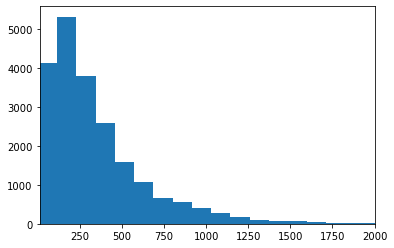

In [28]:
plt.xlim(xmin=10, xmax = 2000)
plt.hist(df_clean['complaint_len'], bins=100)

<AxesSubplot:xlabel='complaint_len', ylabel='count'>

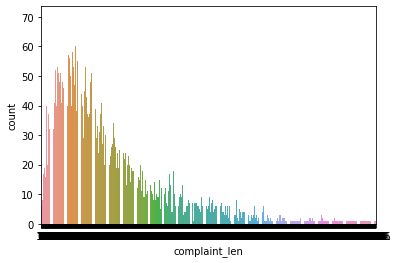

In [29]:
sns.countplot(x='complaint_len', data=df_clean)

#### Find the top 40 words by frequency among all the articles after processing the text.

In [30]:
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 153.1/153.1 kB 4.6 MB/s eta 0:00:00


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [40]:
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

In [35]:
text_articles = ''

In [36]:
for i in range(df_clean.shape[0]):
    val = str(df_clean['complaint_POS_removed'])
    tokens = val.split()
    for i in range (len(tokens)):
        tokens[i] = tokens[i].lower()
    text_articles += " ".join(tokens)+" "

(-0.5, 799.5, 799.5, -0.5)

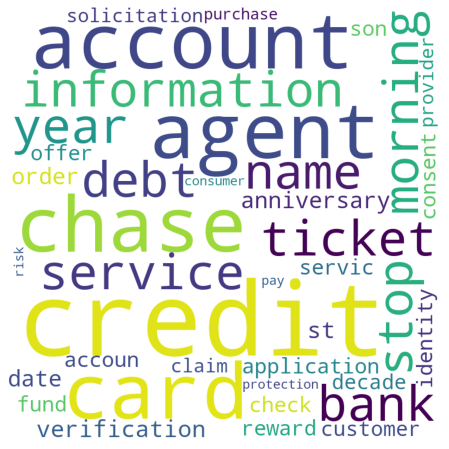

In [43]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
stopwords = set(STOPWORDS)
word_counter = Counter(text_articles.split())
most_occur = word_counter.most_common(50)
top_50_words = ''
for i in range(len(most_occur)):
    top_50_words += most_occur[i][0]+' '
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(top_50_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")

In [ ]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [ ]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 


In [ ]:
#Print the top 10 words in the unigram frequency


In [ ]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 


In [ ]:
#Print the top 10 words in the bigram frequency

In [ ]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 


In [ ]:
#Print the top 10 words in the trigram frequency

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [ ]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [ ]:
#All masked texts has been removed
df_clean

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [ ]:
#Write your code here to initialise the TfidfVectorizer 



#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [ ]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [ ]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [ ]:
#Load your nmf_model with the n_components i.e 5
num_topics = #write the value you want to test out

#keep the random_state =40
nmf_model = #write your code here

In [ ]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

In [ ]:
#Print the Top15 words for each of the topics


In [ ]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4



In [ ]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = #write your code to assign topics to each rows.

In [ ]:
df_clean.head()

In [ ]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [ ]:
#Create the dictionary of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Create the dictionary again of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=

In [ ]:
training_data

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:

#Write your code to get the Vector count


#Write your code here to transform the word vector to tf-idf

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics



